# 6. CLIP

Contrastive Language-Image Pre-Training or [CLIP](https://github.com/openai/CLIP/tree/main) is a text and image encoding tool used with many popular Generative AI models such as [DALL-E](https://openai.com/dall-e-2) and [Stable Diffusion](https://github.com/Stability-AI/stablediffusion).

CLIP in itself is not a Generative AI model, but is instead used to align text encodings with image encodings. If there is such a thing as the perfect text description of an image, the goal of CLIP is to create the same vector embedding for both the image and the text. Let's see what this means in practice.

The goals of this notebook are to:
* Learn how to use CLIP Encodings
  * Get an image encoding
  * Get a text encoding
  * Calculate the cosine similarity between them
* Use CLIP to create a text-to-image neural network


**References**

* [CLIP (GitHub)](https://github.com/openai/CLIP/tree/main)
* [DALL·E by OpenAI](https://openai.com/dall-e-2)
* [Stable Diffusion (GitHub)](https://github.com/Stability-AI/stablediffusion)

In [ ]:
!pip install git+https://github.com/openai/CLIP.git -q --use-pep517

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import csv
import glob
import math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from einops.layers.torch import Rearrange

# Visualization tools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from IPython.display import display
from IPython.display import Image as ImageDisplay
from torchvision.utils import save_image, make_grid
from textwrap import wrap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Notebook is using device: {device}")

Notebook is using device: cuda


## 6.1 Encodings
There are a few different variations of CLIP based on popular image recognition neural networks:

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

For this notebook, we will be using `ViT-B/32`, which is based on the [Vision Transformer](https://huggingface.co/docs/transformers/main/model_doc/vit) architecture. It has `512` features, which we will later feed into our diffusion model.

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

### 5.1.1 Image Encodings

When we load CLIP, it will also come with a set of image transformations we can use to feed images into the CLIP model:

In [ ]:
clip_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7e03541deb60>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
## Dataset is heavy. So mounting to drive use the dataset while running in the colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We can test this on one of our flower photos. Let's start with a picturesque daisy.

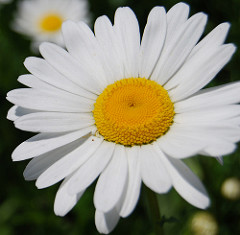

In [ ]:

# DATA_DIR = "data/cropped_flowers/"
DATA_DIR = "/content/drive/MyDrive/data/cropped_flowers/"
img_path = DATA_DIR + "daisy/2877860110_a842f8b14a_m.jpg"
img = Image.open(img_path)
img

We can find the CLIP embedding by first transforming our image with `clip_preprocess` and converting the result to a tensor. Since the `clip_model` expects a batch of images, we can use [np.stack](https://numpy.org/doc/stable/reference/generated/numpy.stack.html) to turn the processed image into a single element batch.

In [ ]:
clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
clip_imgs.size()

torch.Size([1, 3, 224, 224])

In [ ]:
np.stack([clip_preprocess(img)]).shape

(1, 3, 224, 224)

Then, we can pass the batch to `clip_model.encode_image` to find the embedding for the image. Uncomment `clip_img_encoding` if you would like to see what an encoding looks like. When we print the size, it lists `512` features for our `1` image.

In [ ]:
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())
#clip_img_encoding

torch.Size([1, 512])


### 6.1.2 Text Encodings

Now that we have an image encoding, let's see if we can get a matching text encoding. Below is a list of different flower descriptions. Like with the images, the text needs to be preprocessed before it can be encoded by CLIP. To do this, CLIP comes with a `tokenize` function in order to convert each word into an integer.

In [ ]:
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A red rose bud"
]
text_tokens = clip.tokenize(text_list).to(device)
text_tokens

tensor([[49406,   320,  2522,  1579, 12865,   593,   320,  4481,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   550,  4287, 21559,   593,   320,  1205,  2866,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

Then, we can pass the tokens to `encode_text` to get our text encodings. Uncomment `clip_text_encodings` if you would like to see what an encoding looks like. Similar to our image encoding, there are `512` features for each of our `3` images.

In [ ]:
clip_text_encodings = clip_model.encode_text(text_tokens).float()
print(clip_text_encodings.size())
#clip_text_encodings

torch.Size([3, 512])


### 6.1.3 Similarity

In order to see which one of our text descriptions best describes the daisy, we can calculate the [cosine similarity](https://medium.com/@milana.shxanukova15/cosine-distance-and-cosine-similarity-a5da0e4d9ded) between the text encodings and the image encodings. When the cosine similarity is `1`, it's a perfect match. When the cosine similarity is `-1`, the two encodings are opposites.

The cosine similarity is equivalent to a [dot product](https://mathworld.wolfram.com/DotProduct.html) with each vector normalized by their magnitude. In other words, the magnitude of each vector becomes `1`.

We can use the following formula to calculate the dot product:

$X \cdot Y = \sum_{i=1}^{n} x_i y_i = x_1y_1 + x_2 y_2 + \cdots  + x_n y_n$

In [ ]:
clip_img_encoding /= clip_img_encoding.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)
similarity = (clip_text_encodings * clip_img_encoding).sum(-1)
similarity

tensor([0.3707, 0.2473, 0.1768], device='cuda:0', grad_fn=<SumBackward1>)

What do you think? Does the most descriptive text get the highest score?

In [ ]:
for idx, text in enumerate(text_list):
    print(text, " - ", similarity[idx])

A round white daisy with a yellow center  -  tensor(0.3707, device='cuda:0', grad_fn=<SelectBackward0>)
An orange sunflower with a big brown center  -  tensor(0.2473, device='cuda:0', grad_fn=<SelectBackward0>)
A red rose bud  -  tensor(0.1768, device='cuda:0', grad_fn=<SelectBackward0>)


Let's practice a little more. Below, we've added a sunflower and a rose image.

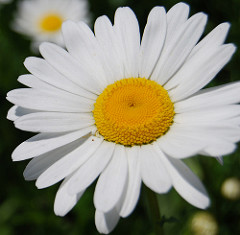

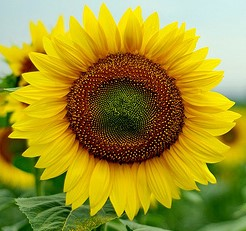

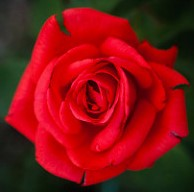

In [ ]:
img_paths = [
    DATA_DIR + "daisy/2877860110_a842f8b14a_m.jpg",
    DATA_DIR + "sunflowers/2721638730_34a9b7a78b.jpg",
    DATA_DIR + "roses/8032328803_30afac8b07_m.jpg"
]

imgs = [Image.open(path) for path in img_paths]
for img in imgs:
    display(img)

In [ ]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

In [ ]:
clip_img_encodings = get_img_encodings(imgs)
clip_img_encodings

tensor([[-0.2717, -0.0157, -0.1792,  ...,  0.5811,  0.0866, -0.1448],
        [ 0.2595, -0.1020, -0.3438,  ..., -0.0073,  0.4958,  0.0819],
        [-0.0620,  0.4136,  0.0090,  ...,  0.3269,  0.4626, -0.1388]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)

In [ ]:
# describe the image in above
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A deep red rose flower"
]

```python
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A deep red rose flower"
]
```

In [ ]:
text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()
clip_text_encodings

tensor([[-0.5107,  0.1919,  0.1963,  ...,  0.0949, -0.0848, -0.2783],
        [ 0.0224,  0.3889,  0.3506,  ...,  0.1219,  0.0778, -0.1910],
        [-0.1094,  0.0110,  0.3333,  ...,  0.1288, -0.1019, -0.1853]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

It would be nice to compare each combination of text and image. To do so, we can [repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html#torch.Tensor.repeat) each text encoding for each image encoding. Similarly, we can [repeat_interleave](https://pytorch.org/docs/stable/generated/torch.repeat_interleave.html) each image encoding for each text encoding.

In [ ]:
clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

n_imgs = len(imgs)
n_text = len(text_list)

In [ ]:
repeated_clip_text_encodings = clip_text_encodings.repeat(n_imgs, 1)
repeated_clip_text_encodings

tensor([[-0.0729,  0.0274,  0.0280,  ...,  0.0135, -0.0121, -0.0397],
        [ 0.0031,  0.0545,  0.0492,  ...,  0.0171,  0.0109, -0.0268],
        [-0.0135,  0.0014,  0.0410,  ...,  0.0158, -0.0125, -0.0228],
        ...,
        [-0.0729,  0.0274,  0.0280,  ...,  0.0135, -0.0121, -0.0397],
        [ 0.0031,  0.0545,  0.0492,  ...,  0.0171,  0.0109, -0.0268],
        [-0.0135,  0.0014,  0.0410,  ...,  0.0158, -0.0125, -0.0228]],
       device='cuda:0', grad_fn=<RepeatBackward0>)

In [ ]:
repeated_clip_img_encoding = clip_img_encodings.repeat_interleave(n_text, dim=0)
repeated_clip_img_encoding

tensor([[-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        ...,
        [-0.0053,  0.0356,  0.0008,  ...,  0.0282,  0.0399, -0.0120],
        [-0.0053,  0.0356,  0.0008,  ...,  0.0282,  0.0399, -0.0120],
        [-0.0053,  0.0356,  0.0008,  ...,  0.0282,  0.0399, -0.0120]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ViewBackward0>)

In [ ]:
similarity = (repeated_clip_text_encodings * repeated_clip_img_encoding).sum(-1)
similarity = torch.unflatten(similarity, 0, (n_text, n_imgs))
similarity

tensor([[0.3705, 0.2471, 0.1943],
        [0.2647, 0.2993, 0.1810],
        [0.1700, 0.1754, 0.3078]], device='cuda:0', grad_fn=<ViewBackward0>)

Let's compare. Ideally, the diagonal from the top left to the bottom right should be a bright yellow corresponding to their high value. The rest of the values should be low and blue.

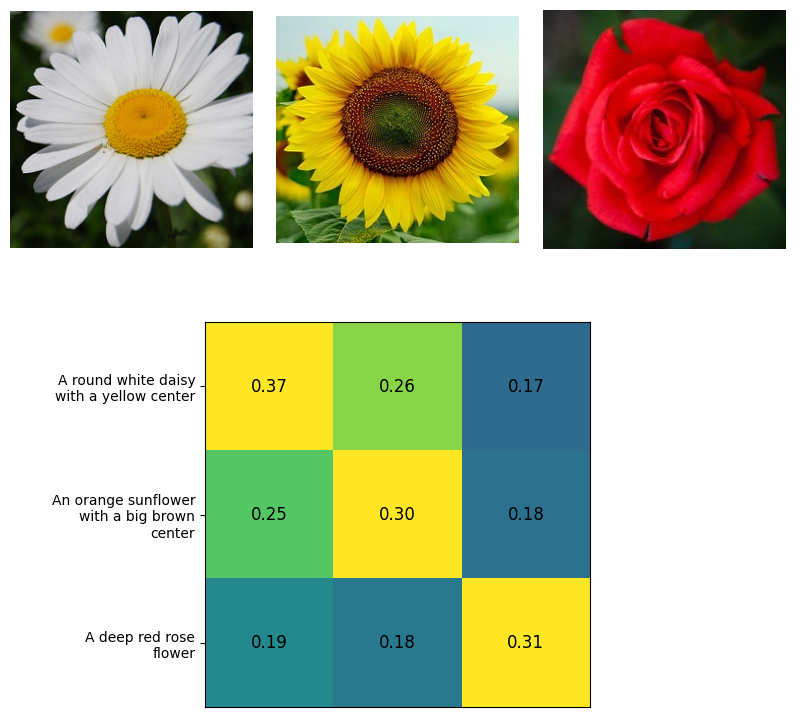

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

for i, img in enumerate(imgs):
    ax = fig.add_subplot(gs[0, i])
    ax.axis("off")
    plt.imshow(img)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.detach().cpu().numpy().T, vmin=0.1, vmax=0.3)

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(n_text), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)

## 6.2 A CLIP Dataset

In the previous notebook, we used the flower category as the label. This time, we're going to use CLIP encodings as our label.

If the goal of CLIP is to align text encodings with image encodings, do we need a text description for each of the images in our dataset? Hypothesis: we do not need text descriptions and only need the image CLIP encodings to create a text-to-image pipeline.

To test this out, let's add the CLIP encodings as the "label" to our dataset. Running CLIP on each batch of data augmented images would be more accurate, but it is also slower. We can speed things up by preprocessing and storing the encodings ahead of time.

We can use [glob](https://docs.python.org/3/library/glob.html) to list all of our image filepaths:

In [ ]:
data_paths = glob.glob(DATA_DIR + '*/*.jpg', recursive=True)
data_paths[:5]

['/content/drive/MyDrive/data/cropped_flowers/sunflowers/40410814_fba3837226_n.jpg',
 '/content/drive/MyDrive/data/cropped_flowers/sunflowers/15042911059_b6153d94e7_n.jpg',
 '/content/drive/MyDrive/data/cropped_flowers/sunflowers/22992257000_76dbc599e7_m.jpg',
 '/content/drive/MyDrive/data/cropped_flowers/sunflowers/40410963_3ac280f23a_n.jpg',
 '/content/drive/MyDrive/data/cropped_flowers/sunflowers/2588234269_c4bfd0d8b9_n.jpg']

The next code block runs the following loop for each filepath:
* Open the image associated with the path and store it in `img`
* Preprocess the image, find the CLIP encoding, and store it in `clip_img`
* Convert the CLIP encoding from a tensor to a python list
* Store the filepath and the CLIP encoding as a row in a csv file

In [ ]:
csv_path = 'clip.csv'

with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for idx, path in enumerate(data_paths):
        img = Image.open(path)
        clip_img = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
        label = clip_model.encode_image(clip_img)[0].tolist()
        writer.writerow([path] + label)

It may take a few seconds to process the full dataset. When complete, open [clip.csv](clip.csv) to see the results.

We can use the same image transformations as we did with the other notebook:

In [ ]:
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

pre_transforms = [
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
]
pre_transforms = transforms.Compose(pre_transforms)
random_transforms = [
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
]
random_transforms = transforms.Compose(random_transforms)

Below is the code to initialize our new dataset. Since we've `preprocessed_clip`, we will preload it onto our GPU with the `__init__` function. We've kept the "on the fly" CLIP encoding as an example. It will produce slightly better results, but it is much slower.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, csv_path, preprocessed_clip=True):
        self.imgs = []
        self.preprocessed_clip = preprocessed_clip
        if preprocessed_clip:
            self.labels = torch.empty(
                len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
            )

        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                img = Image.open(row[0])
                self.imgs.append(pre_transforms(img).to(device))
                if preprocessed_clip:
                    label = [float(x) for x in row[1:]]
                    self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        if self.preprocessed_clip:
            label = self.labels[idx]
        else:
            batch_img = img[None, :, :, :]
            encoded_imgs = clip_model.encode_image(clip_preprocess(batch_img))
            label = encoded_imgs.to(device).float()[0]
        return img, label

    def __len__(self):
        return len(self.imgs)

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

In [ ]:
train_data = MyDataset(csv_path)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

The U-Net model is the same architecture as last time, but with one small difference. Instead of using the number of classes as our `c_embed_dim`, we will use the number of `CLIP_FEATURES`. Last time, `c` might have stood for "class", but this time, it stands for "context". Thankfully, they both start with `c`, so we do not need to refactor the code to reflect this change in intention.

**[Denoising Diffusion Probabilistic Modeling(DDPM)](https://arxiv.org/abs/2006.11239)**

In [ ]:
class DDPM:
    def __init__(self, B, device):
        self.B = B
        self.T = len(B)
        self.device = device

        # Forward diffusion variables
        self.a = 1.0 - self.B
        self.a_bar = torch.cumprod(self.a, dim=0)
        self.sqrt_a_bar = torch.sqrt(self.a_bar)  # Mean Coefficient
        self.sqrt_one_minus_a_bar = torch.sqrt(1 - self.a_bar) # St. dev. coefficient

        # Reverse diffusion variables
        self.sqrt_a_inv = torch.sqrt(1 / self.a)
        self.pred_noise_coeff = (1 - self.a) / torch.sqrt(1 - self.a_bar)

    def q(self, x_0, t):
        """
        The forward diffusion process
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        t = t.int()
        noise = torch.randn_like(x_0)
        sqrt_a_bar_t = self.sqrt_a_bar[t, None, None, None]
        sqrt_one_minus_a_bar_t = self.sqrt_one_minus_a_bar[t, None, None, None]

        x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
        return x_t, noise

    def get_loss(self, model, x_0, t, *model_args):
        x_noisy, noise = self.q(x_0, t)
        noise_pred = model(x_noisy, t, *model_args)
        return F.mse_loss(noise, noise_pred)

    @torch.no_grad()
    def reverse_q(self, x_t, t, e_t):
        """
        The reverse diffusion process
        Returns the an image with the noise from time t removed and time t-1 added.
        model: the model used to remove the noise
        x_t: the noisy image at time t
        t: timestep
        model_args: additional arguments to pass to the model
        """
        t = t.int()
        pred_noise_coeff_t = self.pred_noise_coeff[t]
        sqrt_a_inv_t = self.sqrt_a_inv[t]
        u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
        if t[0] == 0:  # All t values should be the same
            return u_t  # Reverse diffusion complete!
        else:
            B_t = self.B[t - 1]  # Apply noise from the previous timestep
            new_noise = torch.randn_like(x_t)
            return u_t + torch.sqrt(B_t) * new_noise

    @torch.no_grad()
    def sample_images(self, model, img_ch, img_size, ncols, *model_args, axis_on=False):
        # Noise to generate images from
        x_t = torch.randn((1, img_ch, img_size, img_size), device=self.device)
        plt.figure(figsize=(8, 8))
        hidden_rows = self.T / ncols
        plot_number = 1

        # Go from T to 0 removing and adding noise until t = 0
        for i in range(0, self.T)[::-1]:
            t = torch.full((1,), i, device=self.device).float()
            e_t = model(x_t, t, *model_args)  # Predicted noise
            x_t = self.reverse_q(x_t, t, e_t)
            if i % hidden_rows == 0:
                ax = plt.subplot(1, ncols + 1, plot_number)
                if not axis_on:
                    ax.axis("off")
                show_tensor_image(x_t.detach().cpu())
                plot_number += 1
        plt.show()

@torch.no_grad()
def sample_w(model, ddpm, input_size, T, c, device, w_tests=None, store_freq=10):
    if w_tests is None:
        w_tests = [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]

    # Preprase "grid of samples" with w for rows and c for columns
    n_samples = len(w_tests) * len(c)

    # One w for each c
    w = torch.tensor(w_tests).float().repeat_interleave(len(c))
    w = w[:, None, None, None].to(device)  # Make w broadcastable
    x_t = torch.randn(n_samples, *input_size).to(device)

    # One c for each w
    c = c.repeat(len(w_tests), 1)

    # Double the batch
    c = c.repeat(2, 1)

    # Don't drop context at test time
    c_mask = torch.ones_like(c).to(device)
    c_mask[n_samples:] = 0.0

    x_t_store = []
    for i in range(0, T)[::-1]:
        # Duplicate t for each sample
        t = torch.tensor([i]).to(device)
        t = t.repeat(n_samples, 1, 1, 1)

        # Double the batch
        x_t = x_t.repeat(2, 1, 1, 1)
        t = t.repeat(2, 1, 1, 1)

        # Find weighted noise
        e_t = model(x_t, t, c, c_mask)
        e_t_keep_c = e_t[:n_samples]
        e_t_drop_c = e_t[n_samples:]
        e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c

        # Deduplicate batch for reverse diffusion
        x_t = x_t[:n_samples]
        t = t[:n_samples]
        x_t = ddpm.reverse_q(x_t, t, e_t)

        # store values for animation
        if i % store_freq == 0 or i == T or i < 10:
            x_t_store.append(x_t)
    x_t_store = torch.stack(x_t_store)
    return x_t, x_t_store

**[UNet](https://arxiv.org/abs/1505.04597)**

In [ ]:
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=10):
        super().__init__()
        self.T = T
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4  # 2 ** (len(down_chs) - 1)
        small_group_size = 8
        big_group_size = 32

        # Inital convolution
        self.down0 = ResidualConvBlock(img_ch, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x, t, c, c_mask):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / self.T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t)
        t_emb1 = self.t_emb1(t)
        t_emb2 = self.t_emb2(t)

        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)

        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)
        return self.out(torch.cat((up2, down0), 1))


def get_context_mask(c, drop_prob, num_classes):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=num_classes).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

In [ ]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

ddpm = DDPM(B, device)
model = UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=CLIP_FEATURES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model_flowers = torch.compile(model.to(device))

Num params:  44900355


The `get_context_mask` function will change a little bit. Since we're replacing our categorical input with a CLIP embedding, we no longer need to one-hot encode our label. We'll still randomly set values in our encoding to `0` to help the model learn without context.

In [ ]:
def get_context_mask(c, drop_prob):
    c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
    return c_mask

Let's also recreate the `sample_flowers` function. This time, it will take our `text_list` as a parameter and convert it to a CLIP encoding.

In [ ]:
def sample_flowers(text_list):
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    return x_gen, x_gen_store

Time to get training! After about `50` `epochs`, the model will start generating something recognizable, and at `100` it will hit its stride. What do you think? Do the generated images match your descriptions?

In [ ]:
epochs=100
c_drop_prob = 0.1
lrate = 1e-4
save_dir = "05_images"
Path(save_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x, c = batch
        c_mask = get_context_mask(c, c_drop_prob)
        loss = ddpm.get_loss(model_flowers, x, t, c, c_mask)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
    if epoch % 5 == 0 or epoch == int(epochs - 1):
        x_gen, x_gen_store = sample_flowers(text_list)
        grid = make_grid(x_gen.cpu(), nrow=len(text_list))
        save_image(grid, save_dir + f"image_ep{epoch:02}.png")
        print("saved images in " + save_dir + f" for episode {epoch}")

Epoch 0 | Step 008 | Loss: 0.5764484405517578
saved images in 05_images for episode 0
Epoch 1 | Step 008 | Loss: 0.24069958925247192
Epoch 2 | Step 008 | Loss: 0.20178338885307312
Epoch 3 | Step 008 | Loss: 0.1753353327512741
Epoch 4 | Step 008 | Loss: 0.19027107954025269
Epoch 5 | Step 008 | Loss: 0.1953868716955185
saved images in 05_images for episode 5
Epoch 6 | Step 008 | Loss: 0.14506733417510986
Epoch 7 | Step 008 | Loss: 0.14795556664466858
Epoch 8 | Step 008 | Loss: 0.13539427518844604
Epoch 9 | Step 008 | Loss: 0.17105649411678314
Epoch 10 | Step 008 | Loss: 0.14172214269638062
saved images in 05_images for episode 10
Epoch 11 | Step 008 | Loss: 0.13209691643714905
Epoch 12 | Step 008 | Loss: 0.15784989297389984
Epoch 13 | Step 008 | Loss: 0.13992422819137573
Epoch 14 | Step 008 | Loss: 0.1195950135588646
Epoch 15 | Step 008 | Loss: 0.13217946887016296
saved images in 05_images for episode 15
Epoch 16 | Step 008 | Loss: 0.1238740086555481
Epoch 17 | Step 008 | Loss: 0.1183717

Now that the model is trained, let's play with it! What happens when we give it a prompt of something not in the dataset? Or can you craft the perfect prompt to generate an image you can imagine?

The art of crafting a prompt to get the results you desire is called **prompt engineering**, and as shown here, is dependent on the kind of data the model is trained on.

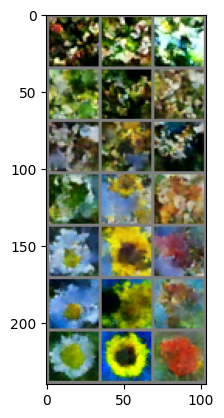

In [ ]:
# Change me
text_list = [
    "A daisy",
    "A sunflower",
    "A rose"
]

model.eval()
x_gen, x_gen_store = sample_flowers(text_list)
grid = make_grid(x_gen.cpu(), nrow=len(text_list))
show_tensor_image([grid])
plt.show()

In [ ]:
def save_animation(frames, gif_name, interval=300, repeat_delay=5000):
    fig, ax = plt.subplots()
    ax.axis("off")
    imgs = [[ax.imshow(frame, animated=True)] for frame in frames]

    animate = animation.ArtistAnimation(
        fig, imgs,
        interval=interval, repeat_delay=repeat_delay, blit=False)
    animate.save(gif_name)
    plt.close()

def to_image(tensor, to_pil=True):
    tensor = (tensor + 1) / 2
    # Clamp to [0, 1] using min and max stacks
    # we may directly use the torch.clamp(tensor, 0, 1)
    ones = torch.ones_like(tensor)
    tensor = torch.min(torch.stack([tensor, ones]), 0)[0]
    zeros = torch.zeros_like(tensor)
    tensor = torch.max(torch.stack([tensor, zeros]), 0)[0]
    if not to_pil:
        return tensor
    return transforms.functional.to_pil_image(tensor)

Once you've found a set of images you enjoy, run the below cell to turn it into an animation. It will be saved to `05_images/flowers.gif`

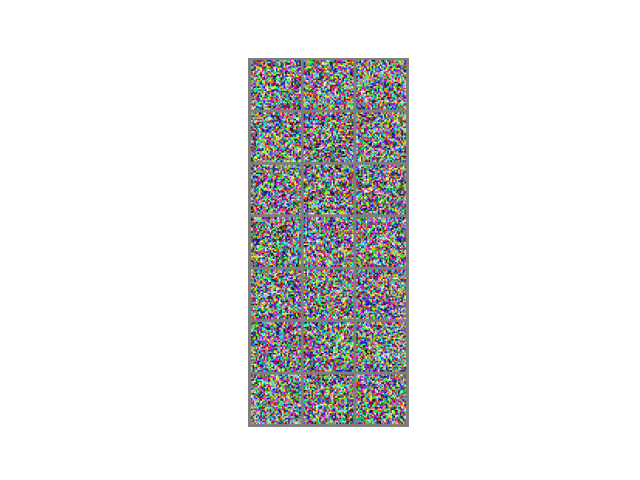

In [ ]:
grids = [to_image(make_grid(x_gen.cpu(), nrow=len(text_list))) for x_gen in x_gen_store]
save_animation(grids, "05_images/flowers.gif")
ImageDisplay(open("05_images/flowers.gif",'rb').read())

## 6.3 Next

Congratulations on making it to the end of the course! Hope the journey was enjoyable and you were able to generate something worthy of sharing with your friends and family.

Ready to put your skills to the test?
Head on over to the assessment to earn a certificate!

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}